# RL homework 1
**Due date: March 2nd, 2021, 11am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: Alexandra Maria Proca

Student number: 20047328

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms (without running experiments or extensive calculations)

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [1]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
np.random.seed(0)

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1
**[8 pts]** Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.name = name
    self._bonus_multiplier=bonus_multiplier
    self.reset()

  def step(self, previous_action, reward):
    if previous_action == None:
        return np.random.randint(self._number_of_arms)
    else:
        self.N[previous_action] += 1
        self.t += 1
        U = self._bonus_multiplier*np.sqrt(np.log(self.t)/self.N)
        alpha = 1/self.N[previous_action]
        error = reward-self.Q[previous_action]
        self.Q[previous_action] += alpha*error
        if len(np.where(self.N == 0)[0]) >= 1:
            return np.random.choice(np.argwhere(self.N == 0)[0])
        else:
            ind = np.argwhere(self.Q+U == np.max(self.Q+U)).flatten()
            if len(ind) > 1:
                return np.random.choice(ind)
            else:
                return np.argmax(self.Q+U)

  def reset(self):
    self.t = 0
    self.N = np.zeros((self._number_of_arms))
    self.Q = np.zeros((self._number_of_arms))

## Q2
**[8 pts]** Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, epsilon):
    self.name = name
    self._number_of_arms = number_of_arms
    self._epsilon=epsilon
    self.reset()

  def step(self, previous_action, reward):
    if previous_action == None:
        return np.random.randint(self._number_of_arms)
    else:
        self.t += 1
        self.N[previous_action] += 1
        alpha = 1/self.N[previous_action]
        error = reward-self.Q[previous_action]
        self.Q[previous_action] += alpha*error
        if callable(self._epsilon):
            decision = bool(np.random.rand() < 1-self._epsilon(self.t))
        else:
            decision = bool(np.random.rand() < 1-self._epsilon)
        if decision:
            maximum = np.max(self.Q)
            ind = np.argwhere(self.Q == np.max(self.Q)).flatten()
            if len(ind) > 1:
                return np.random.choice(ind)
            else:
                return np.argmax(self.Q)
        else:
            return np.random.randint(self._number_of_arms)

  def reset(self):
    self.N = np.zeros((self._number_of_arms))
    self.Q = np.zeros((self._number_of_arms))
    self.t = 0

## Q3
**[12 pts]** Implement a softmax REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [57]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline):
    self._number_of_arms = number_of_arms
    self.name = name
    self._step_size = step_size
    self._baseline = baseline
    self.reset()

  def step(self, previous_action, reward):
    if previous_action == None:
        return np.random.randint(self._number_of_arms)
    else:
        self.N[previous_action] += 1
        self.R[previous_action] += reward
        bsum = np.sum(self.P**2)
        if self._baseline:
            self.avgreward += self._step_size*(reward-self.avgreward)
            rew = self.avgreward
            prefa = self.P[previous_action]+2*self._step_size*(reward-rew)*((1/self.P[previous_action])-(self.P[previous_action]/bsum))
            self.P -= 2*self._step_size*(reward-rew)*(self.P/bsum)
        else:
            rew = 0
            prefa = self.P[previous_action]+2*self._step_size*(reward-rew)*((1/self.P[previous_action])-(self.P[previous_action]/bsum))
            self.P -= 2*self._step_size*(reward-rew)*(self.P/bsum)
        self.P[previous_action] = prefa
        
        policy = np.zeros((self._number_of_arms))
        for action in range(0, len(self.P)):
            policy[action] = (self.P[action]**2)/(np.sum(self.P**2))

        action = np.random.choice(list(range(len(self.P))),p = policy)
        return action
    
  def reset(self):
    self.N = np.zeros((self._number_of_arms))
    self.R = np.zeros((self._number_of_arms))
    self.P = np.ones((self._number_of_arms))
    self.avgreward = 0
    self.base = np.zeros((self._number_of_arms))

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [63]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


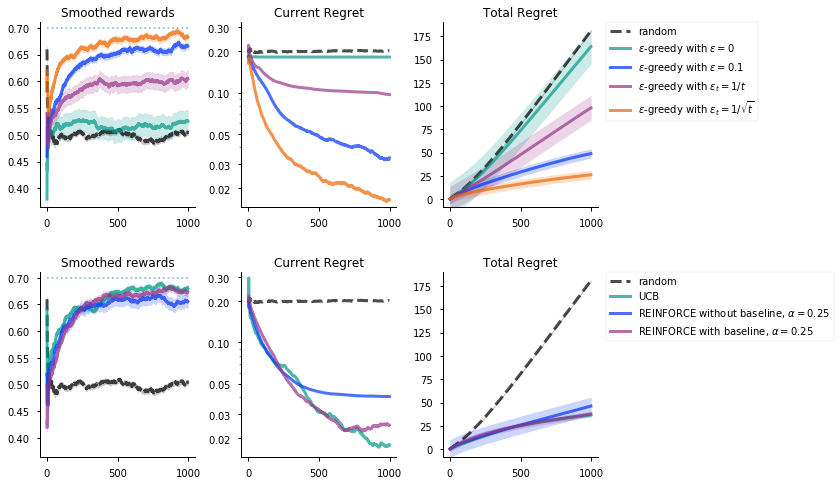

In [64]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** For the best two algorithms from the above plots, explain whether
we would in general expect this algorithm to do well, and why.

> The best two algorithms in the above plots are UCB and $\epsilon$-greedy with $\epsilon=1/\sqrt{t}$. UCB would in general be expected to do well because it balances exploration and exploitation- it favors actions which either have a high action value or which have high uncertainty and thus can explore the action space sufficiently while converging towards an optimal action (it always continues exploring but not too much). Specifically,  UCB with a bonus multiplier $c=\sqrt{2}$ (as used in this experiment) is known to achieve logarithmic expected total regret (Auer et al., 2002). This translates to near optimal performance, as *asymptotic total regret is at least logarithmic in the number of steps* (Lai and Robbins). The performance of UCB depends partially on the bonus multipler $c$, as it modulates the level of exploration versus exploitation: in this setting, $c$ is chosen to facilitate both adequately. Additionally, UCB is guaranteed to converge to the optimal action value for a finite state and action space with stationary rewards because it takes each action in each state infinitely many times as $t \rightarrow \infty$, as according to the Greedy in the Limit with Infinite Exploration (GLIE) theorem. <br/> <br/>
$\epsilon$-greedy with $\epsilon=1/ \sqrt{t}$ is also expected to do well because $\epsilon$ is initially high, aiming to maximize exploration at the beginning of the episode when there is also a high relative uncertainty about actions. $\epsilon$ decays over time, performing well as it heavily exploits the action deemed optimal and minimizing exploration. Additionally, $\epsilon$-greedy with $\epsilon=1/ \sqrt{t}$ is guaranteed to converge to the optimal action value for a finite state and action space with stationary rewards because it takes each action in each state infinitely many times as $t \rightarrow \infty$, as according to the GLIE theorem. Compared to $\epsilon=1/t$, $\epsilon=1/ \sqrt{t}$ decays at a slower rate and therefore has more of an opportunity to explore the action-space, while still decaying over time to exploit a greedy policy.

**[5pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms.

> $\epsilon$-greedy with $\epsilon=0$ performs the worst out of the 4 $\epsilon$ settings ($0,0.1,1/t,1/\sqrt{t}$); with $\epsilon=0$, the algorithm is just greedy. Thus, in this setting, it will continuously exploit the first random action it takes that yields a value of 1 once, without further exploration, although the action itself may be suboptimal. $\epsilon$-greedy with $\epsilon=0.1$ performs better than $\epsilon=0$, as it continues to explore with probability 0.1, allowing it to better evaluate the action values. However, even after actions have been well-explored, it continues to deviate from the current maximum action value, which prevents the model from exploiting the found optimum to its full potential- it still performs well, but must deviate for 10% of actions. It also takes longer to find an optimum because it only explores on average once every 10 iterations. In contrast, $\epsilon=1/\sqrt{t}$ begins with a high probability of exploration and decays with time- this results in faster convergence to a better optimum, as actions are heavily explored at first, when uncertainty is highest, and then are more heavily exploited, which is advantageous as many actions have been explored over many time steps. Thus, unlike $\epsilon=0.1$, it heavily explores at first and stops exploring as $t\rightarrow \infty$, whereas $\epsilon=0.1$ continues to explore at the same rate. Finally, $\epsilon=1/t$ also decays with time, converging to a better value than the greedy algorithm, but worse than $\epsilon=0.1,1/\sqrt{t}$. This setting decays more aggressively, causing it to limit exploration more quickly and to instead exploit more, earlier- thus it performs worse as it explores less and may not be exploiting the optimal action.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [60]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


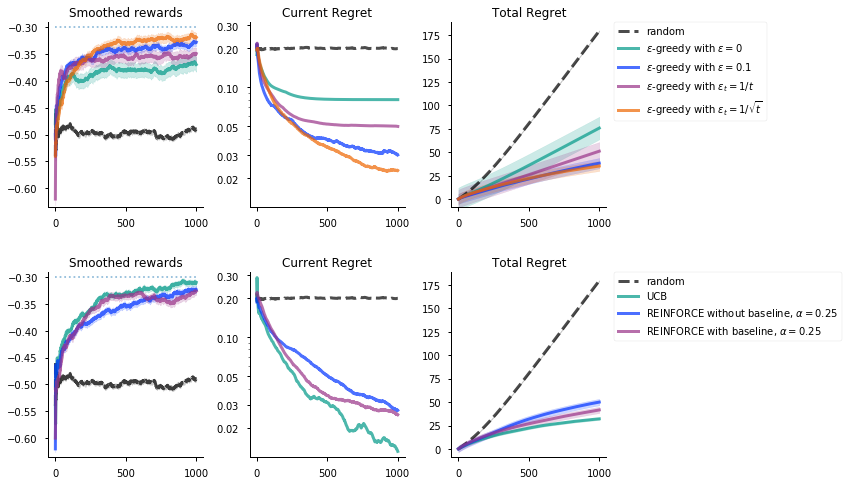

In [61]:
experiment2.show()

## Q6
**[8pts]** For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

> The performance changes significantly for the $\epsilon$-greedy model with $\epsilon=0$, due to the fact that the rewards change to being -1 and 0 and thus, rather than exploiting only the first random action to yield a reward of 1 (as in experiment 1), the algorithm is forced to explore when failures are encountered, as the action-value is penalized (and therefore may no longer be the maximum action). Thus, the setting of experiment 2 forces $\epsilon=0$ model to be less biased towards successes, as in experiment 1. <br/> <br/>
The performance of $\epsilon$-greedy with $\epsilon=0.1$ does not significantly change as the algorithm continues to explore at a constant rate and converge towards an optimum to exploit; the change in reward values does not significantly affect the outcome because the algorithm already explores adequately (10% exploration rate), without the need to be facilitated by the reward setting. <br/> <br/>
The performance of $\epsilon$-greedy with $\epsilon=1/t$ significantly improves from experiment 1, due to the fact that even with a rapid decay of $\epsilon$, the algorithm is still forced to explore more actions because of the action-value penalty given for a failure (similarly to the case of $\epsilon=0$); thus, the algorithm aggressively explores at first and, despite $\epsilon$'s rapid decay, continues to explore different actions if it receives a reward of -1. Because $\epsilon=1/t$ was hindered by decaying too quickly in experiment 1, it performs better in experiment 2, allowed to continue exploring. Thus, the setting of experiment 2 forces $\epsilon=1/t$ model to be less biased towards successes in actions that have been explored, as in experiment 1. <br/> <br/>
The performance of $\epsilon=1/\sqrt{t}$ remains approximately the same, as it still explores sufficiently initially due to the slow decay of $\epsilon$ and is able to determine an optimal action in experiment 1 in the same way as experiment 2, even if the setting of experiment 2 encourages exploration (the model is already exploring at a sufficient level so that the reward setting has little influence on performance). The algorithm balances exploration and exploitation and thus is less biased towards successes as in other models. <br/> <br/>
UCB does not perform significantly different from experiment 1 due to the fact that the algorithm encourages exploration of actions with high uncertainty and exploitation of actions with higher values of uncertainty or expected reward. Thus, the change in reward, although generally encourages exploration when failures are encountered, does not significantly change performance as UCB already explores sufficiently for the purposes of finding an optimum and achieves close-to-optimal performance. <br/> <br/>
REINFORCE with baseline, $\alpha=0.25$ does not perform significantly different from experiment 1, as the preferences are updated as usual and still encourage exploration because it utilizes a stochastic policy, allowing for probabilistic exploration. Additionally the use of a baseline causes the model to be less biased towards successes, therefore yielding a lesser impact of the settings of experiment 2 (which reduce bias towards successes) on performance. <br/> <br/>
Finally, REINFORCE without baseline, $\alpha=0.25$ performs significantly better than experiment 1, as the reward being (0,-1) results in a preference with a reward of -1 being negatively penalized, rather than remaining the same value as in experiment 1- thus all actions begin with the same perferences and undesirable preferences are negatively weighted. This allows the algorithm to explore the actions which have not yet been taken more because of their higher reward, rather than favoring the actions which have already been taken and yielded a favorable reward; this reduces the bias of the model towards successes and forces the algorithm to explore more. The algorithm is initially more biased towards successes (as opposed to REINFORCE with baseline) and thus has a significant change in performance when the bias towards success is reduced.

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


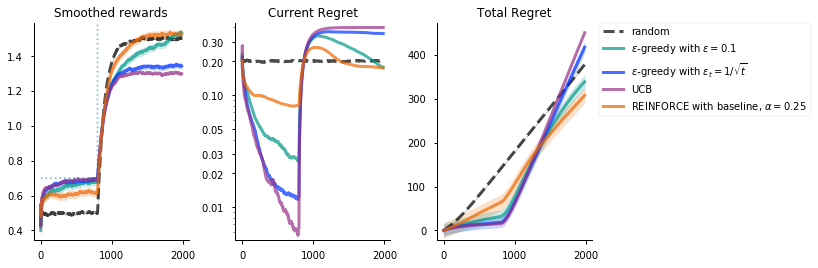

In [14]:
experiment3.show()

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [15]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


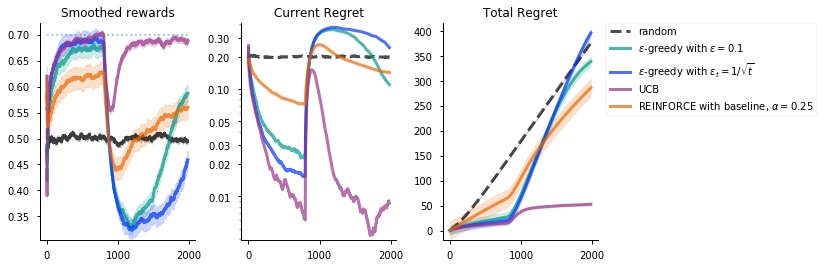

In [16]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[8 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> After the change in rewards, UCB has the highest current regret, due to the fact that each action has been explored and so the count for each action $N$ is high compared to $t$, yielding a low value for $U$: there is assumed to be a small uncertainty for these actions and they are therefore not called, as their corresponding action values are also smaller than the actions that were previously yielding more successes. Thus, UCB continues to exploit the actions that previously resulted in the greatest reward, rarely exploring other actions and is not robust to changes in other actions' rewards. Additionally, UCB achieves the lowest regret prior to the reward change (closest to optimal and smaller number of failures) and thus, selects the actions yielding successes the most out of all the algorithms, resulting in the highest regret after the change. <br/> <br/>
$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$ achieves the next worse performance because $\epsilon$ is already substantially decayed at the point of change and thus the algorithm does rarely explores and instead heavily exploits the action which has already been determined to have a high action value, making it inflexible to changes in other rewards. Additionally, as with UCB, because it is close-to-optimal at the time of the reward switch, it naturally selects actions yielding previously low failure and thus misses the new reward of +2. <br/><br/>
$\epsilon$-greedy with $\epsilon=0.1$ performs slightly better because it continues exploiting the same action, but since it does not achieve optimal performance before the change, its new current-regret is slightly less than UCB and $\epsilon_t=1/\sqrt{t}$ as it is more likely to yield failures (+2 reward). Additionally, $\epsilon=0.1$ continues exploring with a probability of 0.1 and thus its regret gradually decreases as it begins increasing the action values of actions resulting in a reward of +2. <br/> <br/>
Finally, REINFORCE with baseline, $\alpha=0.25$ yields the best performance after the change because its algorithm utilizes a stochastic policy to select the next action and thus continues exploring other actions- this leads it to also update its preferences, upweighting actions yielding +2, and eventually downweighting actions yielding +1.

**[8 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> After the change in rewards, $\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$ has the highest regret because $\epsilon$ is already substantially decayed at that point and thus, the algorithm rarely explores and instead exploits the action with the previous maximum action value. However, as the optimum action value decays, other actions are gradually explored and the regret begins to decrease as other actions' action-values increase. <br/> <br/>
$\epsilon$-greedy with $\epsilon=0.1$ achieves the next highest regret initially because it is also accustomed to exploit a certain action; however, because $\epsilon=0.1$ is constant, it continues exploring with probability 0.1 in addition to the optimal action-value decaying. Thus its regret decreases more rapidly as it finds another action to exploit instead more quickly, having a higher rate of exploration. <br/> <br/>
REINFORCE with baseline, $\alpha=0.25$ yields the next highest regret after the change because its preferences are biased towards certain actions, making it more difficult to escape the learned optimum. However, because the algorithm utilizes a stochastic policy to select the next action, it still continues exploring other actions in addition to its optimum action value decaying; this leads it to also update its preferences, upweighting actions yielding +1, and downweighting actions yielding 0. <br/> <br/>
Finally, UCB yields the lowest regret because its action value rapidly decays and its uncertainty of actions increases with each time step, forcing it to explore actions that have been taken less times and thus allowing it to adapt to the change and switch actions rapidly, yielding a lower regret.

**[4 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> The current-regret curve for UCB in experiment 3 differs from the curve in experiment 4 because in experiment 3 the reward of the successes does not change. Thus, the action value for the converged optimal action remains constant and due to the earlier exploration of actions (high $N_t(a)$), U is not large enough to encourage exploration of other actions at those time steps. In this setting, UCB does not explore other actions to the extent that will cause a significant deviation in action values. Alternatively, in experiment 4, the value of the successes decreases, which in turn causes the action value to decrease. The previously optimal action value therefore is no longer the maximum action value and other action values are then explored, having increased U's over time. Therefore, UCB is able to change its policy to an optimal action and decrease its current regret further.

**[4 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

> The $\epsilon$-greedy algorithm could be modified by including a discount factor (step-size) parameter to rewards further in the past so as to give more weight to recent rewards, in order to make the policy more flexible to change as it is more strongly influenced by current reward values. <br/>
$Q_t(a)=\frac{\sum^t_{i=0} \alpha ^{t-i} \delta[A=a]R}{\sum ^{t}_{i=0} \alpha ^{t-i} \delta [ A=a]}$ <br/>
This could be done while keeping a constant $\epsilon$ value (e.g. $\epsilon=0.1$) to ensure the agent continues exploring with time and can quickly modify its action-values with non-stationarity. Another alternative solution could be to have an $\epsilon$ comprised of a decaying factor ($1/\sqrt{t}$) and a constant factor ($[0,0.1$]), in order to balance an aggressive initial exploration with gradual decay, while still exploring: for example, $\epsilon=1/\sqrt{t}+0.05$.

**[8 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> UCB could be modified with a discount factor (step-size) to instead increase the relative weight of immediate expected reward. Using this method, the UCB policy would average past rewards with a discount factor $\alpha \in [0,1]$ giving more weight to more recent observations, allowing it to be more flexible to perturbations in reward (non-stationarity). Specifically, <br/>
$N_{t}( a) =\sum ^{t}_{i=0} \alpha ^{t-i} \delta [ A=a]$ <br/>
$\pi(a)=\arg \max_a (Q_t(a)+U_t(a)$ <br />
$= \arg \max_a(\frac{\sum^t_{i=0} \alpha ^{t-i} \delta[A=a]R}{N_t(a)} +c\sqrt{\frac{\log (\sum ^{t}_{i=0} \alpha ^{t-i})}{N_t(a)}})$ <br /> <br/>
Thus, such a method would facilitate UCB to explore actions which have not recently been taken, as the denominator $N_t(a)$ increases more with actions that have been recently taken, while not drastically affecting the performance of UCB short-term. 

# C) Reasoning about algorithms

## Q8

Consider the UCB algorithm. Suppose we have two actions, $a$ and $b$. Consider the initial exploration bonus for each to be infinite, as long as we have not selected the corresponding action, so that the algorithm first selects each action at least once.

Suppose action $a$ yields a Bernoulli random reward with $p(R=1 \mid a) = 1/3$ and $p(R=0 \mid a) = 2/3$.  Action $b$ also yields a Bernoulli random reward, but with $p(R=1 \mid b) = 2/3$ and $p(R=0 \mid b) = 1/3$.

**[7 pts]** What is the probability (before seeing any data) of selecting action $a$ on the third time step (at which point we will have selected both $a$ and $b$ exactly once)?  (Break ties uniformly, if relevant.)

> $p(R=1|a)=\frac{1}{3}$ <br/>
$p(R=0|a)=\frac{2}{3}$ <br/>
$p(R=1|b)=\frac{2}{3}$ <br/>
$p(R=0|b)=\frac{1}{3}$ <br/>
Because $N_t(a)=N_t(b)$, $U_t(a)=U_t(b)$ <br/> 
Thus, for UCB, <br/>
$p(A_3=a|A_1,A_2)=\frac{1}{2}p(Q_t(a)=Q_t(b))+p(Q_t(a)>Q_t(b))$ <br/>
$=\frac{1}{2}(p(R=0|a)p(R=0|b)+p(R=1|a)p(R=1|b))+p(R=1|a)p(R=0|b)$ <br/>
$=\frac{1}{2}((\frac{2}{3})(\frac{1}{3})+(\frac{1}{3})(\frac{2}{3}))+(\frac{1}{3})(\frac{1}{3})$ <br/>
$=\frac{1}{3}$

## Q9

Consider a bandit with two arms, $a$ and $b$.  So far, we have seen the following actions and rewards, on time steps $t=1$ and $t=2$:
\begin{align*}
t=1\,:\qquad A_1=a~,~ R_1=0\\
t=2\,:\qquad A_2=b~,~ R_2=1 
\end{align*}
The rewards are known to be Bernoulli random variables (so $R_t \in \{0, 1\}$) with unknown means.

Consider a Thompson sampling algorithm to select actions, with a uniform Beta prior at time $t=0$ such that the probability density functions for the expected reward for both actions before seeing any data (at time $t=0$) are defined by $p(E[R] = x\mid a) = 1$, for all $x\in[0,1]$, and all $a$.


**[7 pts]** What is the probability under Thompson sampling of $A_3 = a$? Show your calculations, but keep it concise.
ADD EXPLANATION
> At $t=1$: $q(a)=\mathrm{Beta}(1,2)$, $q(b)=\mathrm{Beta}(1,1)$ <br/>
At $t=2$: $q(a)=\mathrm{Beta}(1,2)$, $q(b)=\mathrm{Beta}(1,2)$ <br/>
$p(A_3=a|A_1,A_2)=p(q(a)>q(b))$ <br /> 
$\Rightarrow p(\mathrm{Beta}(1,2)>\mathrm{Beta}(2,1))$ <br /> 
$=\int ^{1}_{0}\frac{x^{1-1}( 1-x)^{2-1} \Gamma ( 1+2)}{\Gamma ( 1) \Gamma ( 2)}\left(\int ^{x}_{0}\frac{y^{2-1}( 1-y)^{1-1} \Gamma ( 2+1)}{\Gamma ( 2) \Gamma ( 1)} dy\right) dx$ <br /> $=\int ^{1}_{0}\frac{( 1-x) \Gamma ( 3)}{\Gamma ( 1) \Gamma ( 2)}\left(\int ^{x}_{0}\frac{y\Gamma ( 3)}{\Gamma ( 2) \Gamma ( 1)} dy\right) dx$ <br /> $=\int ^{1}_{0} 2( 1-x)\left(\int ^{x}_{0} 2ydy\right) dx$ <br /> $=\int ^{1}_{0}( 2-2x)\left( x^{2}\right) dx$ <br /> $=\int ^{1}_{0}\left( 2x^{2} -2x^{3}\right) dx$ <br /> $=\frac{2}{3} -\frac{1}{2}$ <br /> $=\frac{1}{6}$ <br /> 
$p(A_3=a|A_1,A_2)=\frac{1}{6}$

## Q10

Consider a tabular ergodic MDP, and consider the following algorithm: 

On each time step $t$ we use UCB in the state we are currently in to determine the action to take.  Specifically, use and update the required statistics for UCB locally, for that state. In other words, in each state we update the UCB statistics as if that state is a bandit problem. 

However, instead of averaging the immediate rewards to use as action values, we use one-step Q-learning with a step size $\alpha_t$ to predict action values with some discount $\gamma \in [0, 1]$.

**[8 pts]** Is this algorithm guaranteed to converge to the optimal value function $q_*$ (for any finite MDP with well-defined values, e.g., $\gamma<1$) for an appropriately chosen step size schedule $\{ \alpha_t \}_{t=0}^\infty$?  Prove your answer, but be concise.  (E.g., this proof should not include lengthy calculations, you don't have to specify a concrete step size schedule, etc.)

> According to Greedy in the Limit with Infinite Exploration (GLIE) Theorem, for any finite MDP with well-defined values for an apporpiately chosen step-size schedule, *Q-learning control converges to the optimal action-value function, $q \rightarrow q*$, as long as we take each action in each state infinitely often.* <br /> <br/>
The UCB algorithm can be written as: <br />
$\pi(a)=\arg \max_a (Q_t(a)+U_t(a)$ <br />
$= \arg \max_a(q(s,a)+c\sqrt{\frac{\log t}{N_t(a)}})$ <br />
For a given state, as $t \rightarrow \infty$, there must be at least one action $a_i$ for which $N_t(a_i)\rightarrow \infty$, where $U_t(a_i)$ is finite. Instead, for all actions $a_j$ where $N_t(a_j)$ is finite, <br/>
$U_t(a_j)=c\sqrt{\frac{\log t}{N_t(a_j)}} \rightarrow \infty$ <br />
Then, because $Q_t(a)$ is finite for all actions and $U_t(a_j)\rightarrow \infty$, while $U_t(a_i)$ is finite, <br/>
$\pi (a)=a_j$ <br/>
for all actions $a_j$ where $N_t(a_j)$ is finite, until each action $a_j$ is chosen infinitely many times ($N_t(a_j) \rightarrow \infty$). Thus each action must be taken infinitely many times as $t \rightarrow \infty$. <br/> <br/>
Because the MDP is tabular, there are a finite number of states, and because the MDP is ergodic, each state has a non-zero probability of being reached from any other state. Therefore, as each action for each state is taken infinitely many times and each state can be reached from any other state, every state is visited infinitely many times. <br/> <br/>
Thus, as $t\rightarrow \infty$, UCB ensures each action in each state is taken infinitely many times and, according to the GLIE theorem, it converges to the optimal action value $q \rightarrow q*$